# Оцениваем регрессии на данных HS0 в спецификациях:
- Фиксированные эффекты ~ ковид и ограничения
- Фиксированные эффекты ~ ковид и ограничения | инструментальные переменные
- В перспективе: суммарный экспорт/импорт в зависимости от ковида (+ IV)

In [1]:
library(arrow)
library(stargazer)
library(tidyverse)
library(plotly)
library(fixest)


Присоединяю пакет: 'arrow'


Следующий объект скрыт от 'package:utils':

    timestamp



Please cite as: 


 Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.3. https://CRAN.R-project.org/package=stargazer 


Warning message:
"пакет 'tidyverse' был собран под R версии 4.4.2"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::duration() masks arrow::duration()
✖ dplyr::filter()       masks stats::filter()
✖ dplyr::lag()          masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"пакет 'plotly' был собран под R версии 4.4.2"

Присоеди

## Фиксированные эффекты

### Экспорт

+иллюстрирую, зачем тут нужны фиксированные эффекты

In [2]:
# Скачиваю данные и переназываю переменные
df = read_parquet('../data/processed_data/trade_hs0_export_fe_x_covid.parquet.gzip')
df = df %>% mutate(year = as.character(year), SARS_flg = as.integer(!is.na(SARS_total_cases)))
df %>% head()


year,country,value,country:r,t,cases,deaths,tests,C1M_School_closing,C2M_Workplace_closing,⋯,infant_mortality,largest_city_share,urbanization,country:household_size,avg_hh_size,share_1_members,share_2_3_members,share_4_5_members,year:r,SARS_flg
<chr>,<chr>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
2020,SLV,4.858130,SLV,2020,19.6259116,0.57060773,NA,2.426229,1.4344262,⋯,11.0,24.14867,17.73575,SLV,3.92,8.46,36.01,37.84,2020,0
2022,ASM,-6.219868,ASM,2022,467.6200274,1.92600000,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,2022,0
2020,BOL,5.237020,BOL,2020,35.1308840,2.07754144,NA,2.418033,1.8306011,⋯,21.0,22.42107,41.25143,BOL,3.53,20.34,34.82,27.64,2020,0
2020,SLE,2.576115,SLE,2020,0.8507182,0.02530387,NA,1.606557,0.2349727,⋯,80.3,35.38844,15.18978,SLE,5.29,6.42,20.52,33.28,2020,0
2020,LKA,7.712751,LKA,2020,4.9664917,0.02309392,NA,1.931694,0.5546448,⋯,6.0,14.93368,NA,NA,NA,NA,NA,NA,2020,0
2022,ATG,-4.746044,ATG,2022,143.9042740,0.82619178,NA,NA,NA,⋯,8.1,NA,NA,NA,NA,NA,NA,NA,2022,0


### Рисую обычный и demeaned scatterplot, чтобы обосновать необходимость использования фиксированных эффектов

Графики будут интерактивные, если раскомментить ggplotly, закомментить p и перепрогнать

Warning message:
"Removed 128 rows containing missing values or values outside the scale range
(`geom_point()`)."


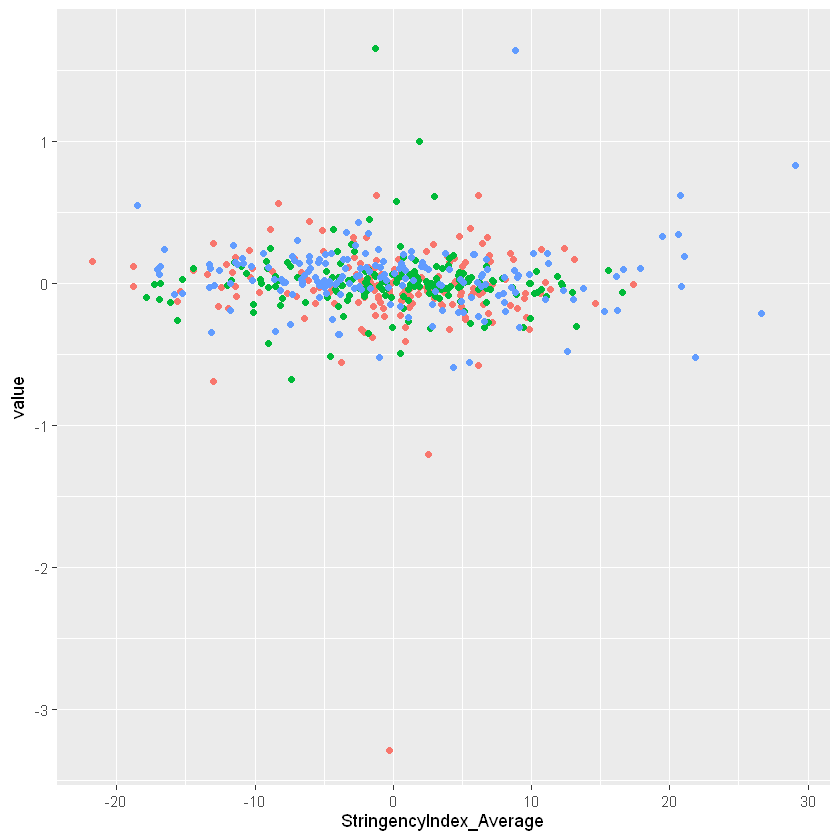

In [4]:
country_means_df = df %>% group_by(country) %>%
 summarize(avg_value = mean(value, na.rm = TRUE), avg_StringencyIndex_Average = mean(StringencyIndex_Average, na.rm = TRUE))

demeaned_df = df %>% merge(., country_means_df, by = 'country')  %>%
  mutate(StringencyIndex_Average = StringencyIndex_Average- avg_StringencyIndex_Average, value = value- avg_value) %>%
   select(country, year, StringencyIndex_Average, value)
   
year_means_df = demeaned_df %>% group_by(year) %>%
 summarize(avg_value = mean(value, na.rm = TRUE), avg_StringencyIndex_Average = mean(StringencyIndex_Average, na.rm = TRUE))

demeaned_df2 = demeaned_df %>% merge(., year_means_df, by = 'year')  %>%
  mutate(StringencyIndex_Average = StringencyIndex_Average- avg_StringencyIndex_Average, value = value - avg_value) %>%
   select(country, year, StringencyIndex_Average, value)

p = ggplot(demeaned_df2, aes(x = StringencyIndex_Average, y = value, text = factor(country), color = factor(year)
    )) + geom_point()+ theme(legend.position = "none")
# ggplotly(p)    
p

### Сами регрессии

In [5]:
# Pulled OLS
export_pulled_ols = feols(value ~ log(deaths) +
 StringencyIndex_Average| year,
 data = df)
export_pulled_ols %>% summary(vcov = ~country)

NOTE: 156 observations removed because of NA and infinite values (LHS: 2, RHS: 154).



OLS estimation, Dep. Var.: value
Observations: 503
Fixed-effects: year: 3
Standard-errors: Clustered (country) 
                        Estimate Std. Error t value   Pr(>|t|)    
log(deaths)             0.524724   0.110739 4.73840 4.4569e-06 ***
StringencyIndex_Average 0.018684   0.018433 1.01366 3.1215e-01    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 2.99351     Adj. R2: 0.436824
                Within R2: 0.128344

In [6]:
export_fe_ols = feols(value ~ log(deaths) +
 StringencyIndex_Average| country + year,
 data = df)
export_fe_ols %>% summary(vcov = ~country)

NOTE: 156 observations removed because of NA and infinite values (LHS: 2, RHS: 154).



OLS estimation, Dep. Var.: value
Observations: 503
Fixed-effects: country: 175,  year: 3
Standard-errors: Clustered (country) 
                         Estimate Std. Error  t value Pr(>|t|)    
log(deaths)             -0.029375   0.012601 -2.33122 0.020888 *  
StringencyIndex_Average -0.001757   0.001390 -1.26337 0.208147    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.174355     Adj. R2: 0.997063
                 Within R2: 0.027457

In [7]:
# Тут всё экзогенно
export_covid_iv = feols(value ~ 1 + StringencyIndex_Average|country + year|
 log(deaths) ~ 
#  H6M_Facial_Coverings+
 C1M_School_closing+median_age+population_density,
 data = df)
export_covid_iv %>% summary(vcov = ~country)

NOTE: 158 observations removed because of NA and infinite values (LHS: 2, RHS: 126, IV: 74/130).



TSLS estimation - Dep. Var.: value
                  Endo.    : log(deaths)
                  Instr.   : C1M_School_closing, median_age, population_density
Second stage: Dep. Var.: value
Observations: 501
Fixed-effects: country: 175,  year: 3
Standard-errors: Clustered (country) 
                         Estimate Std. Error   t value Pr(>|t|) 
fit_log(deaths)          0.034276   0.055603  0.616443  0.53841 
StringencyIndex_Average -0.002944   0.001845 -1.595744  0.11236 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.182672     Adj. R2:  0.99677 
                 Within R2: -0.063851
F-test (1st stage), log(deaths): stat = 5.12746 , p = 0.001683, on 3 and 494 DoF.
                     Wu-Hausman: stat = 0.937527, p = 0.333644, on 1 and 321 DoF.
                         Sargan: stat = 1.33405 , p = 0.513234, on 2 DoF.

In [8]:
export_all_iv = feols(value ~ 1 |country + year|
 log(deaths) + StringencyIndex_Average ~ #H6M_Facial_Coverings+
 C1M_School_closing+median_age+population_density,
 data = df)
export_all_iv %>% summary(vcov = ~country)

NOTE: 158 observations removed because of NA and infinite values (LHS: 2, IV: 154/130).



TSLS estimation - Dep. Var.: value
                  Endo.    : log(deaths), StringencyIndex_Average
                  Instr.   : C1M_School_closing, median_age, population_density
Second stage: Dep. Var.: value
Observations: 501
Fixed-effects: country: 175,  year: 3
Standard-errors: Clustered (country) 
                             Estimate Std. Error   t value Pr(>|t|) 
fit_log(deaths)              0.056799   0.059845  0.949111  0.34388 
fit_StringencyIndex_Average -0.004506   0.002925 -1.540445  0.12527 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.189214     Adj. R2:  0.996534
                 Within R2: -0.141422
F-test (1st stage), log(deaths)            : stat =   8.63355 , p = 1.355e-5, on 3 and 495 DoF.
F-test (1st stage), StringencyIndex_Average: stat = 117.7     , p < 2.2e-16 , on 3 and 495 DoF.
                                 Wu-Hausman: stat =   0.632627, p = 0.531858, on 2 and 320 DoF.
                                     Sargan: stat =   0.

In [9]:
# Гетерогенность во времени
export_time_effects = feols(value ~ year/log(deaths) + year/StringencyIndex_Average| country,
 data = df)
export_time_effects %>% summary(vcov = ~country)

NOTE: 156 observations removed because of NA and infinite values (LHS: 2, RHS: 154).



OLS estimation, Dep. Var.: value
Observations: 503
Fixed-effects: country: 175
Standard-errors: Clustered (country) 
                                  Estimate Std. Error    t value  Pr(>|t|)    
year2021                         -5.054656   0.143238 -35.288439 < 2.2e-16 ***
year2022                         -5.094831   0.152739 -33.356520 < 2.2e-16 ***
year2020:log(deaths)             -0.036097   0.016491  -2.188913  0.029935 *  
year2021:log(deaths)             -0.029316   0.015828  -1.852174  0.065695 .  
year2022:log(deaths)             -0.022349   0.013791  -1.620544  0.106926    
year2020:StringencyIndex_Average -0.004144   0.002811  -1.474399  0.142181    
year2021:StringencyIndex_Average -0.001306   0.001806  -0.723238  0.470505    
year2022:StringencyIndex_Average  0.001000   0.001840   0.543252  0.587651    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.172732     Adj. R2: 0.997082
                 Within R2: 0.994195

In [10]:
# Гетерогенность во времени
export_covid_time_effects = feols(value ~ year/log(deaths)| country,
 data = df)
export_covid_time_effects %>% summary(vcov = ~country)
# Ядро крашится почему-то
# feols(value ~ 1| country|
# year/log(deaths)~C1M_School_closing+median_age+population_density,
#  data = df) %>% summary(vcov = ~country)

NOTE: 76 observations removed because of NA and infinite values (LHS: 2, RHS: 74).



OLS estimation, Dep. Var.: value
Observations: 583
Fixed-effects: country: 210
Standard-errors: Clustered (country) 
                      Estimate Std. Error    t value   Pr(>|t|)    
year2021             -4.898938   0.031134 -157.35089  < 2.2e-16 ***
year2022             -4.868733   0.033772 -144.16483  < 2.2e-16 ***
year2020:log(deaths) -0.052960   0.015411   -3.43655 0.00071073 ***
year2021:log(deaths) -0.045316   0.015409   -2.94095 0.00364076 ** 
year2022:log(deaths) -0.033211   0.014880   -2.23194 0.02668008 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.189434     Adj. R2: 0.996996
                 Within R2: 0.992858

In [11]:
etable(export_fe_ols, export_time_effects, export_covid_iv, vcov = ~country, fitstat=~ . + sargan.p + wh.p + ivf)

,,export_fe_ols,export_time_effe..,export_covid_iv
,<chr>,<chr>,<chr>,<chr>
1,Dependent Var.:,value,value,value
2,,,,
3,log(deaths),-0.0294* (0.0126),,0.0343 (0.0556)
4,StringencyIndex_Average,-0.0018 (0.0014),,-0.0029 (0.0018)
5,year2021,,-5.055*** (0.1432),
6,year2022,,-5.095*** (0.1527),
7,year2020 x log(deaths),,-0.0361* (0.0165),
8,year2021 x log(deaths),,-0.0293. (0.0158),
9,year2022 x log(deaths),,-0.0223 (0.0138),


In [12]:
etable(export_fe_ols, export_time_effects, export_covid_iv, vcov = ~country, fitstat=~ . + sargan.p + wh.p + ivf, tex=TRUE)

\begingroup
\centering
\begin{tabular}{lccc}
   \tabularnewline \midrule \midrule
   Dependent Variable: & \multicolumn{3}{c}{value}\\
   Model:                                       & (1)            & (2)            & (3)\\  
   \midrule
   \emph{Variables}\\
   log(deaths)                                  & -0.0294$^{**}$ &                & 0.0343\\   
                                                & (0.0126)       &                & (0.0556)\\   
   StringencyIndex\_Average                     & -0.0018        &                & -0.0029\\   
                                                & (0.0014)       &                & (0.0018)\\   
   year2021                                     &                & -5.055$^{***}$ &   \\   
                                                &                & (0.1432)       &   \\   
   year2022                                     &                & -5.095$^{***}$ &   \\   
                                                &                & (0.1527

### Импорт

+иллюстрирую, зачем тут нужны фиксированные эффекты

In [13]:
# Скачиваю данные и переназываю переменные
df = read_parquet('../data/processed_data/trade_hs0_import_fe_x_covid.parquet.gzip')
df = df %>% mutate(year = as.character(year), SARS_flg = as.integer(!is.na(SARS_total_cases)))
df %>% head()

year,country,value,country:r,t,cases,deaths,tests,C1M_School_closing,C2M_Workplace_closing,⋯,infant_mortality,largest_city_share,urbanization,country:household_size,avg_hh_size,share_1_members,share_2_3_members,share_4_5_members,year:r,SARS_flg
<chr>,<chr>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
2020,SLV,2.321174,SLV,2020,19.6259116,0.57060773,NA,2.426229,1.4344262,⋯,11.0,24.14867,17.73575,SLV,3.92,8.46,36.01,37.84,2020,0
2022,ASM,-2.471433,ASM,2022,467.6200274,1.92600000,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,2022,0
2020,BOL,1.776656,BOL,2020,35.1308840,2.07754144,NA,2.418033,1.8306011,⋯,21.0,22.42107,41.25143,BOL,3.53,20.34,34.82,27.64,2020,0
2020,SLE,1.100952,SLE,2020,0.8507182,0.02530387,NA,1.606557,0.2349727,⋯,80.3,35.38844,15.18978,SLE,5.29,6.42,20.52,33.28,2020,0
2020,LKA,3.031731,LKA,2020,4.9664917,0.02309392,NA,1.931694,0.5546448,⋯,6.0,14.93368,NA,NA,NA,NA,NA,NA,2020,0
2022,ATG,-1.252042,ATG,2022,143.9042740,0.82619178,NA,NA,NA,⋯,8.1,NA,NA,NA,NA,NA,NA,NA,2022,0


### Рисую обычный и demeaned scatterplot, чтобы обосновать необходимость использования фиксированных эффектов

Графики будут интерактивные, если раскомментить ggplotly, закомментить p и перепрогнать

Warning message:
"Removed 128 rows containing missing values or values outside the scale range
(`geom_point()`)."


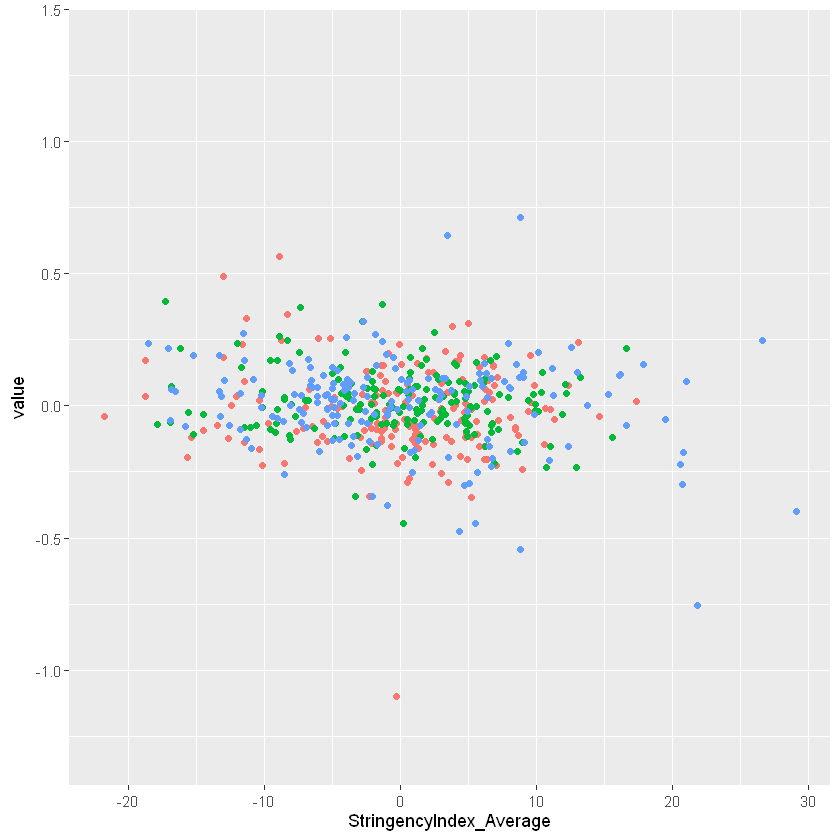

In [15]:
country_means_df = df %>% group_by(country) %>%
 summarize(avg_value = mean(value, na.rm = TRUE), avg_StringencyIndex_Average = mean(StringencyIndex_Average, na.rm = TRUE))

demeaned_df = df %>% merge(., country_means_df, by = 'country')  %>%
  mutate(StringencyIndex_Average = StringencyIndex_Average- avg_StringencyIndex_Average, value = value- avg_value) %>%
   select(country, year, StringencyIndex_Average, value)
   
year_means_df = demeaned_df %>% group_by(year) %>%
 summarize(avg_value = mean(value, na.rm = TRUE), avg_StringencyIndex_Average = mean(StringencyIndex_Average, na.rm = TRUE))

demeaned_df2 = demeaned_df %>% merge(., year_means_df, by = 'year')  %>%
  mutate(StringencyIndex_Average = StringencyIndex_Average- avg_StringencyIndex_Average, value = value - avg_value) %>%
   select(country, year, StringencyIndex_Average, value)

p = ggplot(demeaned_df2, aes(x = StringencyIndex_Average, y = value, text = factor(country), color = factor(year)
    )) + geom_point()+ theme(legend.position = "none")
# ggplotly(p)    
p

### Сами регрессии

In [16]:
# Pulled OLS
import_pulled_ols = feols(value ~ log(deaths) +
 StringencyIndex_Average| year,
 data = df)
import_pulled_ols %>% summary(vcov = ~country)

NOTE: 156 observations removed because of NA and infinite values (LHS: 2, RHS: 154).



OLS estimation, Dep. Var.: value
Observations: 503
Fixed-effects: year: 3
Standard-errors: Clustered (country) 
                        Estimate Std. Error  t value   Pr(>|t|)    
log(deaths)             0.315333    0.07999 3.942170 0.00011684 ***
StringencyIndex_Average 0.010619    0.01352 0.785447 0.43325966    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 2.2034     Adj. R2: 0.194255
               Within R2: 0.088716

In [17]:
import_fe_ols = feols(value ~ log(deaths) +
 StringencyIndex_Average| country + year,
 data = df)
import_fe_ols %>% summary(vcov = ~country)

NOTE: 156 observations removed because of NA and infinite values (LHS: 2, RHS: 154).



OLS estimation, Dep. Var.: value
Observations: 503
Fixed-effects: country: 175,  year: 3
Standard-errors: Clustered (country) 
                         Estimate Std. Error   t value Pr(>|t|) 
log(deaths)              0.001954   0.010623  0.183984  0.85424 
StringencyIndex_Average -0.001685   0.001141 -1.476210  0.14169 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.134983     Adj. R2: 0.995352
                 Within R2: 0.00712 

In [18]:
# Тут всё экзогенно
import_covid_iv = feols(value ~ 1 + StringencyIndex_Average|country + year|
 log(deaths) ~ #H6M_Facial_Coverings+
 C1M_School_closing+median_age+population_density,
 data = df)
import_covid_iv %>% summary(vcov = ~country)

NOTE: 158 observations removed because of NA and infinite values (LHS: 2, RHS: 126, IV: 74/130).



TSLS estimation - Dep. Var.: value
                  Endo.    : log(deaths)
                  Instr.   : C1M_School_closing, median_age, population_density
Second stage: Dep. Var.: value
Observations: 501
Fixed-effects: country: 175,  year: 3
Standard-errors: Clustered (country) 
                         Estimate Std. Error   t value Pr(>|t|) 
fit_log(deaths)          0.020045   0.038515  0.520444  0.60342 
StringencyIndex_Average -0.001830   0.001329 -1.377091  0.17025 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.135713     Adj. R2:  0.995297
                 Within R2: -0.007399
F-test (1st stage), log(deaths): stat = 5.12746 , p = 0.001683, on 3 and 494 DoF.
                     Wu-Hausman: stat = 0.128798, p = 0.719918, on 1 and 321 DoF.
                         Sargan: stat = 2.1758  , p = 0.336923, on 2 DoF.

In [19]:
import_all_iv = feols(value ~ 1 |country + year|
 log(deaths) + StringencyIndex_Average ~ #H6M_Facial_Coverings+
 C1M_School_closing+median_age+population_density,
 data = df)
import_all_iv %>% summary(vcov = ~country)

NOTE: 158 observations removed because of NA and infinite values (LHS: 2, IV: 154/130).



TSLS estimation - Dep. Var.: value
                  Endo.    : log(deaths), StringencyIndex_Average
                  Instr.   : C1M_School_closing, median_age, population_density
Second stage: Dep. Var.: value
Observations: 501
Fixed-effects: country: 175,  year: 3
Standard-errors: Clustered (country) 
                             Estimate Std. Error   t value Pr(>|t|) 
fit_log(deaths)             -0.015805   0.037120 -0.425782  0.67079 
fit_StringencyIndex_Average  0.000657   0.002098  0.313066  0.75461 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.136201     Adj. R2:  0.995263
                 Within R2: -0.014667
F-test (1st stage), log(deaths)            : stat =   8.63355 , p = 1.355e-5, on 3 and 495 DoF.
F-test (1st stage), StringencyIndex_Average: stat = 117.7     , p < 2.2e-16 , on 3 and 495 DoF.
                                 Wu-Hausman: stat =   0.765893, p = 0.465769, on 2 and 320 DoF.
                                     Sargan: stat =   0.

In [20]:
# Гетерогенность во времени
import_time_effects = feols(value ~ year/log(deaths) + year/StringencyIndex_Average| country,
 data = df)
import_time_effects %>% summary(vcov = ~country)

feols(value ~ year/log(deaths) + StringencyIndex_Average| country,
 data = df) %>% summary(vcov = ~country)

NOTE: 156 observations removed because of NA and infinite values (LHS: 2, RHS: 154).



OLS estimation, Dep. Var.: value
Observations: 503
Fixed-effects: country: 175
Standard-errors: Clustered (country) 
                                  Estimate Std. Error    t value  Pr(>|t|)    
year2021                         -1.785907   0.089386 -19.979621 < 2.2e-16 ***
year2022                         -1.483281   0.111039 -13.358228 < 2.2e-16 ***
year2020:log(deaths)             -0.015340   0.012159  -1.261682   0.20875    
year2021:log(deaths)              0.000679   0.014878   0.045615   0.96367    
year2022:log(deaths)              0.013814   0.011194   1.234095   0.21883    
year2020:StringencyIndex_Average -0.001012   0.001886  -0.536605   0.59223    
year2021:StringencyIndex_Average -0.000131   0.001386  -0.094285   0.92499    
year2022:StringencyIndex_Average -0.000956   0.002058  -0.464638   0.64277    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.132798     Adj. R2: 0.995445
                 Within R2: 0.970316

NOTE: 156 observations removed because of NA and infinite values (LHS: 2, RHS: 154).



OLS estimation, Dep. Var.: value
Observations: 503
Fixed-effects: country: 175
Standard-errors: Clustered (country) 
                         Estimate Std. Error    t value  Pr(>|t|)    
year2021                -1.738521   0.022412 -77.572558 < 2.2e-16 ***
year2022                -1.470466   0.046921 -31.339249 < 2.2e-16 ***
StringencyIndex_Average -0.000628   0.001306  -0.480405   0.63154    
year2020:log(deaths)    -0.015827   0.012405  -1.275904   0.20369    
year2021:log(deaths)     0.002514   0.014730   0.170655   0.86469    
year2022:log(deaths)     0.014199   0.011306   1.255899   0.21084    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.13287     Adj. R2: 0.995469
                Within R2: 0.970284

In [21]:
# Гетерогенность во времени
import_covid_time_effects = feols(value ~ year/log(deaths)| country,
 data = df)
import_covid_time_effects %>% summary(vcov = ~country)
# Ядро крашится почему-то
# feols(value ~ 1| country|
# year/log(deaths)~C1M_School_closing+median_age+population_density,
#  data = df) %>% summary(vcov = ~country)

NOTE: 76 observations removed because of NA and infinite values (LHS: 2, RHS: 74).



OLS estimation, Dep. Var.: value
Observations: 583
Fixed-effects: country: 210
Standard-errors: Clustered (country) 
                      Estimate Std. Error    t value  Pr(>|t|)    
year2021             -1.736273   0.021463 -80.896340 < 2.2e-16 ***
year2022             -1.435496   0.020997 -68.368321 < 2.2e-16 ***
year2020:log(deaths) -0.020469   0.011199  -1.827768   0.06901 .  
year2021:log(deaths) -0.000043   0.012479  -0.003408   0.99728    
year2022:log(deaths)  0.014333   0.010783   1.329270   0.18521    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.138164     Adj. R2: 0.995859
                 Within R2: 0.966848

In [22]:
etable(import_fe_ols, import_time_effects, import_covid_iv, vcov = ~country, fitstat=~ . + sargan.p + wh.p + ivf, tex=FALSE)

,,import_fe_ols,import_time_effe..,import_covid_iv
,<chr>,<chr>,<chr>,<chr>
1,Dependent Var.:,value,value,value
2,,,,
3,log(deaths),0.0020 (0.0106),,0.0200 (0.0385)
4,StringencyIndex_Average,-0.0017 (0.0011),,-0.0018 (0.0013)
5,year2021,,-1.786*** (0.0894),
6,year2022,,-1.483*** (0.1110),
7,year2020 x log(deaths),,-0.0153 (0.0122),
8,year2021 x log(deaths),,0.0007 (0.0149),
9,year2022 x log(deaths),,0.0138 (0.0112),


In [23]:
etable(import_fe_ols, import_time_effects, import_covid_iv, vcov = ~country, fitstat=~ . + sargan.p + wh.p + ivf, tex=TRUE)

\begingroup
\centering
\begin{tabular}{lccc}
   \tabularnewline \midrule \midrule
   Dependent Variable: & \multicolumn{3}{c}{value}\\
   Model:                                       & (1)      & (2)            & (3)\\  
   \midrule
   \emph{Variables}\\
   log(deaths)                                  & 0.0020   &                & 0.0200\\   
                                                & (0.0106) &                & (0.0385)\\   
   StringencyIndex\_Average                     & -0.0017  &                & -0.0018\\   
                                                & (0.0011) &                & (0.0013)\\   
   year2021                                     &          & -1.786$^{***}$ &   \\   
                                                &          & (0.0894)       &   \\   
   year2022                                     &          & -1.483$^{***}$ &   \\   
                                                &          & (0.1110)       &   \\   
   year2020 $\times$ log(deaths)    